# Introduction to machine learning

*Maxime Sangnier*

Fall, 2019

## Practical session 2: kernel methods for classification and regression

# Table of contents
1. [Intuitive approach to SVM](#part1)
1. [Classification](#part2)
1. [Regression](#part3)
1. [Regression with precomputed kernel](#part4)
1. [Duality gap](#part5)


In [1]:
from mllab import *


Packages:
	nympy as np
	matplotlib.pyplot as plt
	seaborn as sns

Functions:
	plotXY
	plot_frontiere
	map_regions
	covariance
	plot_cov
	sample_gmm
	scatter
	plot_level_set
	gaussian_sample



# Intuitive approach to SVM <a id="part1"></a>


>The following expression enables to assess, in real time, the impact of a kernel and of the tradeoff parameter $C = \frac{1}{n\lambda}$.

In [2]:
!python3 svm_gui.py


Libsvm GUI

A simple graphical frontend for Libsvm mainly intended for didactic
purposes. You can create data points by point and click and visualize
the decision region induced by different kernels and parameter settings.

To create positive examples click the left mouse button; to create
negative examples click the right button.

If all examples are from the same class, it uses a one-class SVM.




>Make some tests with this GUI.
In particular, design
- linearly separable data / or not;
- unimodal classes / or not,

>and compare
- different kernels;
- different values for C and for hyperparameters (kernel parameters).

>For unimodal classes (first, linearly separable, then not), how do the margin and the frontiere behave with respect to $C$ (for a linear kernel) and to $\gamma$ (for a Gaussian kernel)?

>Are the values for these two parameters decisive for obtaining good classification rates?

**Answer:**

For a linearly separable class, the margin and the frontiere don't depend on $C$ for a linear kernel. For the Gaussian kernel, the lesser $\gamma$, the more the decision ressembles a linear kernel.

For a non-linearly separable class, the margin grows when $C$ shrinks for a linear kernel. For a Gaussian kernel, if $\gamma$ is too large, the model overfits. If $\gamma$ is too small, the decision is similar to a linear kernel.

The values of these two parameters are indeed decivise for obtaining good classification rates.

>Fit a linear classifier on unimodal (but not linearly separable) classes. Add some points one at a time.

>Determine three particular areas for the classifier.
How does the classifier react when adding a point in each area?

>What can we say about the dual variable $\alpha_i$ (associated to each point $X_i$) for each area?

**Answer:**

The three areas are:
+ on the "good side" of the classifier beyond the margin. The classifier does not change when adding a point. $\alpha_i=0$ 
+ on the "good side" of the classifier, between the margin and the frontier: the classifier changes, and the margin slightly decreases. $0 \leq \alpha_i \leq C$ 
+ on the "bad side" of the classifier: the classifier changes, and the margin increases. $\alpha_i=C$ 

>Design a very unbalanced dataset (really more points in a class than in the other).
With a linear kernel, decrease gradually the value of $C$. What do you observe?

>This penomenon can be avoided with a class-dependent weighting of the data-fitting term (parameter `class_weight` of [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)).

**Answer:**

When $C$ decreases, the classifier classifies all points in the largest class.

# Classification <a id="part2"></a>
>Let us consider the dataset defined below.

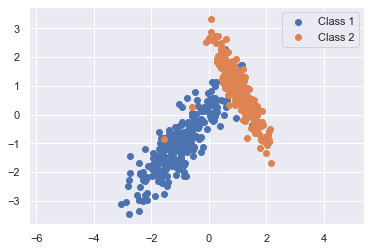

In [3]:
# Classification dataset
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500, n_classes=2,
                           n_features=2, n_redundant=0, n_clusters_per_class=1)

plotXY(X, y)

>For $C \in \{10^{-3}, \dots, 10^{2}\}$, fit a [linear support vector classifier](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and store its classification accuray (also known as score).

>Plot the score vs the values of $C$.

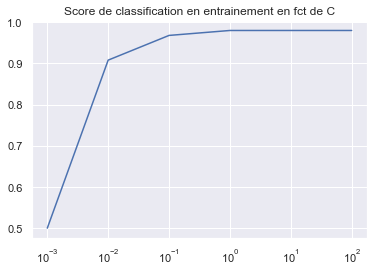

In [4]:
from sklearn.svm import SVC
scores = []
Cs = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]
n_train = 250

for C in Cs:
    clf = SVC(C=C)
    clf.fit(X[:n_train], y[:n_train])
    scores.append(clf.score(X[n_train:], y[n_train:]))
    
plt.xscale('log')
plt.plot(Cs, scores)
plt.title('Score de classification en entrainement en fct de C')
plt.show()

>Determine the value of $C$ leading to the best score.

In [5]:
print('Best C: ' +str(Cs[np.argmax(np.array(scores))]))

Best C: 1


# Regression <a id="part3"></a>
>What about for this dataset?

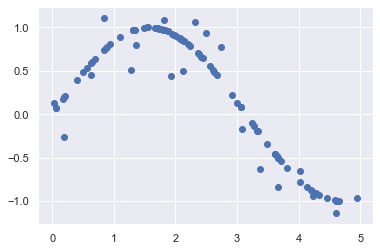

In [6]:
# Regression dataset
n = 100
X_train = np.sort(5 * np.random.rand(n))
y_train = np.sin(X_train)
y_train[::5] += 1 * (0.5 - np.random.rand(n//5))

X_test = np.arange(0, 5, step=1e-2)
y_test = np.sin(X_test)

# Make 2d-arrays
X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]

plt.scatter(X_train, y_train)

Best C: 10.0


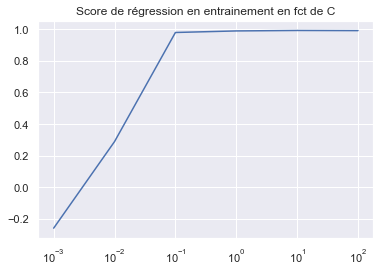

In [7]:
from sklearn.svm import SVR
scores = []
Cs = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]

for C in Cs:
    reg = SVR(C=C)
    reg.fit(X_train, y_train)
    scores.append(reg.score(X_test, y_test))

best_C = Cs[np.argmax(np.array(scores))]
print('Best C: ' +str(best_C))

plt.xscale('log')
plt.plot(Cs, scores)
plt.title('Score de régression en entrainement en fct de C')
plt.show()

**Answer:**
…

>Plot on the same figure the training points and the prediction for the test set.

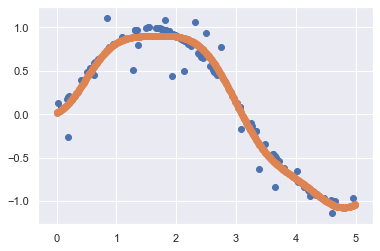

In [8]:
plt.scatter(X_train, y_train)
reg = SVR(C=best_C)
reg.fit(X_train, y_train)
plt.scatter(X_test, reg.predict(X_test))
plt.show()

# Regression with precomputed kernel <a id="part4"></a>


>We focus here on molecule activity prediction.
For this purpose, we consider a molecule to be a graph, represented by a set of relations between its nodes (the atoms of the molecule).
Following these relations in a molecule $x$, we go over a path $p$ in the corresponding graph.
Let $\mathcal P_d$ be the set of all possible paths of length less than $d$ for the family of graph considered.
Let also $I(x, p)$ being $1$ if the path $p$ is in the molecule $x$ and $0$ otherwise.
Then, for two molecules $x$ and $x'$, we can define the similarity measure
$$
    u(x, x') = \sum_{p \in \mathcal P_d} I(x, p) I(x', p).
$$
The *Tanimoto kernel* is then defined by
$$
    k(x, x') = \frac{u(x, x')}{u(x, x) + u(x', x') - u(x, x')}.
$$

>Please, download the [dataset](https://drive.google.com/file/d/0B6VyRTVgbDFeWFFUUVRidUR3MFE/view?usp=sharing) in the directory `./data/` and run the following script to build the train and test kernel matrices.

In [9]:
path = "data_ncicancer/"

# Load the data
K = np.loadtxt(path + "/ncicancer_kernel_hf_ex0.txt") # Load the kernel
y = np.loadtxt(path + "/ncicancer_targets_ex0.txt")[:, 0] # Load the targets
y = (y-np.min(y)) / (np.max(y)-np.min(y)) # Scale the targets

# Split train/test sets
indices = np.random.permutation(K.shape[0])
train_idx, test_idx = indices[:K.shape[0]//4], indices[K.shape[0]//4:]
K_train = K[train_idx][:, train_idx]
y_train = y[train_idx]
K_test = K[test_idx][:, train_idx]
y_test = y[test_idx]

print("Number of training examples:", K_train.shape[0])
print("Number of test examples:", K_test.shape[0])

Number of training examples: 576
Number of test examples: 1729


>We would like to apply support vector regression.
Plot the training and test accuracies for $C=10^{-1}$ and different values of $\epsilon$ in $[10^{-3}, 10^{-1}]$.

Best eps: 0.0069519279617756054
Best accuracy: 0.3077957444692869


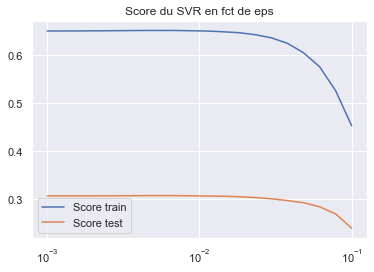

In [10]:
from sklearn.svm import SVR
scores_train = []
scores_test = []
epsilons = np.logspace(-3, -1, 20, base=10)

for eps in epsilons:
    reg = SVR(kernel='precomputed', C=0.1, epsilon=eps)
    reg.fit(K_train, y_train)
    scores_train.append(reg.score(K_train, y_train))
    scores_test.append(reg.score(K_test, y_test))

best_eps = epsilons[np.argmax(np.array(scores_test))]
print('Best eps: ' +str(best_eps))
print('Best accuracy: ' + str(np.max(scores_test)))

plt.xscale('log')
plt.plot(epsilons, scores_train, label='Score train')
plt.plot(epsilons, scores_test, label='Score test')
plt.title('Score du SVR en fct de eps')
plt.legend()
plt.show()

>Do the same with kernel regularized regression.

Best eps: 0.5455594781168517
Best accuracy: 0.2918848477457855


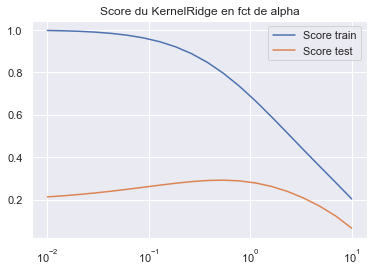

In [11]:
from sklearn.kernel_ridge import KernelRidge
scores_train = []
scores_test = []
alphas = np.logspace(-2, 1, 20, base=10)

for alpha in alphas:
    reg = KernelRidge(kernel='precomputed', alpha=alpha)
    reg.fit(K_train, y_train)
    scores_train.append(reg.score(K_train, y_train))
    scores_test.append(reg.score(K_test, y_test))

best_alphas = alphas[np.argmax(np.array(scores_test))]
print('Best eps: ' +str(best_alphas))
print('Best accuracy: ' + str(np.max(scores_test)))

plt.xscale('log')
plt.plot(alphas, scores_train, label='Score train')
plt.plot(alphas, scores_test, label='Score test')
plt.title('Score du KernelRidge en fct de alpha')
plt.legend()
plt.show()

>Given the kernel matrices for training and testing, give the best possible accuracy on the test sample with a kernel machine.
The testing data should not intervene in fitting the model.

In [12]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

epsilons = np.logspace(-3, -1, 20, base=10)
Cs = np.logspace(-5, 5, 20, base=10)
param_grid = dict(C=Cs, epsilon=epsilons)
clf = GridSearchCV(SVR(kernel='precomputed'), param_grid=param_grid, refit=True, cv=5)
clf.fit(K_train, y_train)

print('Best parameters: %s' %clf.best_params_)
print('Training score: %0.2f' % clf.score(K_train, y_train))
print('Test score: %0.2f' % clf.score(K_test, y_test))

Best parameters: {'C': 0.1623776739188721, 'epsilon': 0.00545559478116852}
Training score: 0.75
Test score: 0.32


/home/pmarion/anaconda3/envs/introML/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


>Compare to regularized regression with kernels.

In [13]:
scores_train = []
scores_test = []
alphas = np.logspace(-2, 1, 20, base=10)
param_grid = dict(alpha=alphas)
clf = GridSearchCV(KernelRidge(kernel='precomputed'), param_grid=param_grid, refit=True, cv=5)
clf.fit(K_train, y_train)

print('Best parameters: %s' %clf.best_params_)
print('Training score: %0.2f' % clf.score(K_train, y_train))
print('Test score: %0.2f' % clf.score(K_test, y_test))

Best parameters: {'alpha': 0.18329807108324356}
Training score: 0.92
Test score: 0.28


/home/pmarion/anaconda3/envs/introML/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Duality gap <a id="part5"></a>


In [14]:
# Dataset
import numpy as np
from sklearn.datasets import load_digits

X, Y = load_digits(return_X_y=True)
Y[Y<5] = 1  # Class 1: digits 1, …, 4
Y[Y>4] = -1  # Class -1: digits 5, …, 9

ind = np.random.permutation(X.shape[0])[:X.shape[0]//4]
X = X[ind]
Y = Y[ind]

print("Digits dataset:")
print("X shape:", X.shape)
print("Labels:", Y.min(), Y.max())

Digits dataset:
X shape: (449, 64)
Labels: -1 1


>After being fitted, the object [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) has many interesting attributes:
- `coef_` (1 x #features): is the vector defining the Riesz representation (primal coefficients);
- `intercept_` (1): is the model intercept;
- `support_` (#support vectors): is the array of indexes of the support vectors;
- `dual_coef_` (1 x #support vectors): is the array of non-zero signed dual variables (that is $y_i \alpha_i$).

>Write a function, called `primal_dual(clf, X_train, y_train)`, that given a classifier object, a data matrix, and a label array, fits the classifier and returns the tuple `(primal, dual)` of primal and dual objective values.
Check, on the dataset previously loaded, that the primal and the dual objectives are close to each other.

In [15]:
from sklearn.svm import SVC

def primal_dual(clf, X_train, y_train):
    clf.fit(X, Y)
    Y_pred = clf.decision_function(X_train)
    loss = 1-Y*Y_pred
    primal = 0.5 * np.linalg.norm(clf.coef_)**2 + clf.C * np.sum(loss[loss>0])
    dual = np.sum(Y[clf.support_]*clf.dual_coef_[0]) - 0.5 * np.dot(clf.dual_coef_, np.dot(np.matmul(X[clf.support_], X[clf.support_].T), clf.dual_coef_.T))[0][0]
    return (primal, dual)

print(primal_dual(SVC(kernel='linear'), X, Y))

(102.53706052212854, 102.53003918792322)


>How does the duality gap (difference between primal and dual objectives) behave with respect to the optimization tolerance (parameter `tol` of [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html))?
To anwser, plot the gap with respect to the tolerance in x-log-scale.

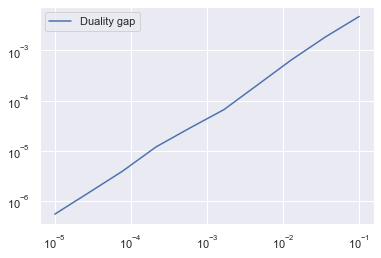

In [16]:
from sklearn.svm import SVC
primals = []
duals = []
tols = np.logspace(-5, -1, 10, base=10)

for tol in tols:
    primal, dual = primal_dual(SVC(kernel='linear', C=0.01, tol=tol), X, Y)
    primals.append(primal)
    duals.append(dual)

plt.xscale('log')
plt.yscale('log')
plt.plot(tols, np.array(primals)-np.array(duals), label='Duality gap')
plt.legend()
plt.show()